# Visualize attributions for FABP1 in enterocytes and hepatocytes

In [1]:
import numpy as np
import pandas as pd
import anndata
import torch
import os, sys
sys.path.append('/code/decima/src/decima')

from lightning import LightningModel
from visualize import plot_marker_box
from interpret import extract_gene_data

from grelu.visualize import plot_attributions, add_highlights, plot_motif
from grelu.transforms.prediction_transforms import Aggregate

from captum.attr import InputXGradient
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from grelu.io.motifs import read_meme_file
from grelu.interpret.motifs import scan_sequences

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_dir="/gstore/data/resbioai/grelu/decima/20240823"
matrix_file = os.path.join(save_dir, "data.h5ad")
h5_file = os.path.join(save_dir, "data.h5")
ckpt_dir = os.path.join(save_dir, 'lightning_logs')
meme_file = '/gstore/data/resbioai/grelu/decima/H12CORE_meme_format.meme'

## Load data

In [3]:
ad = anndata.read_h5ad(matrix_file)

## Load models

In [4]:
ckpts=[
'/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/kugrjb50/checkpoints/epoch=3-step=2920.ckpt',
'/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/i68hdsdk/checkpoints/epoch=2-step=2190.ckpt',
'/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/0as9e8of/checkpoints/epoch=7-step=5840.ckpt',
'/gstore/data/resbioai/grelu/decima/20240823/lightning_logs/i9zsp4nm/checkpoints/epoch=8-step=6570.ckpt',
]
models = [LightningModel.load_from_checkpoint(ckpt).eval() for ckpt in ckpts]

/opt/conda/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
wandb: Currently logged in as: anony-mouse-525

In [5]:
motifs = read_meme_file(meme_file)

## Gene

In [6]:
gene = "FABP1"
interval_start = ad.var.loc[gene, 'start']
interval_end = ad.var.loc[gene, 'end']
ad.var.loc[[gene]]

,chrom,start,end,strand,gene_type,frac_nan,mean_counts,n_tracks,gene_start,gene_end,gene_length,gene_mask_start,gene_mask_end,frac_N,fold,dataset,gene_id,pearson,size_factor_pearson,ensembl_canonical_tss
FABP1,chr2,87767614,88291902,-,protein_coding,0.116969,0.479238,2672,88122982,88128062,5080,163840,168920,0.0,['fold3'],test,ENSG00000163586,0.724881,-0.034163,88128062.0


## Define tasks

In [7]:
e_tasks = ad.obs_names[(ad.obs.organ=='gut') & (ad.obs.cell_type=='enterocyte')].tolist()
h_tasks = ad.obs_names[(ad.obs.organ=='liver') & (ad.obs.cell_type=='hepatocyte')].tolist()

## Get attributions

In [8]:
seq, mask = extract_gene_data(h5_file, gene, merge=False)
inputs = torch.vstack([seq, mask])
tss_pos = np.where(mask[0] == 1)[0][0] - 2
device = torch.device(6)
inputs = inputs.to(device)

In [9]:
%%time

attr_e = []
for model in models:
    model.add_transform(Aggregate(tasks=e_tasks, task_aggfunc="mean", model=model))
    attributer = InputXGradient(model.to(device))
    with torch.no_grad():
        x = attributer.attribute(inputs).cpu().numpy()
        attr_e.append(x)

attr_e = np.stack(attr_e).mean(0)[:4]
attr_e.shape

/opt/conda/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.


CPU times: user 2.78 s, sys: 276 ms, total: 3.06 s
Wall time: 3.06 s


(4, 524288)

In [10]:
%%time

attr_h = []
for model in models:
    model.add_transform(Aggregate(tasks=h_tasks, task_aggfunc="mean", model=model))
    attributer = InputXGradient(model.to(device))
    with torch.no_grad():
            x = attributer.attribute(inputs).cpu().numpy()
            attr_h.append(x)

attr_h = np.stack(attr_h).mean(0)[:4]
attr_h.shape

CPU times: user 2.12 s, sys: 9.75 ms, total: 2.13 s
Wall time: 2.12 s


(4, 524288)

## View large region

64000


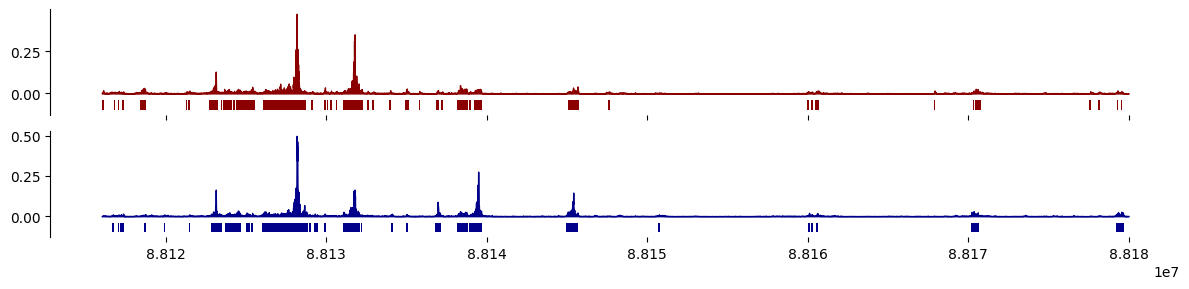

In [11]:
sc = 88116000
ec = 88180000
print(ec-sc)

start_pos = sc - interval_start
end_pos = ec - interval_start
a_e = gaussian_filter1d(np.abs(attr_e[:, ::-1].mean(0)[start_pos:end_pos]), 5)
a_h = gaussian_filter1d(np.abs(attr_h[:, ::-1].mean(0)[start_pos:end_pos]), 5)

fig, axes = plt.subplots(2, 1, figsize=(12, 3), sharex=True, tight_layout=True)

axes[0].fill_between(np.linspace(sc, ec, num=ec-sc), a_e, color="darkred")
sns.despine(top=True, right=True, bottom=True)
p = find_peaks(a_e, height=.01)[0]
add_highlights(
    axes[0], starts=[x-50+sc for x in p], ends=[x+50+sc for x in p],
    facecolor='darkred', ymin=-.1, ymax=-.04, alpha=1)

axes[1].fill_between(np.linspace(sc, ec, num=ec-sc), a_h, color="darkblue")
sns.despine(top=True, right=True, bottom=True)
p = find_peaks(a_h, height=.01)[0]
add_highlights(
    axes[1], starts=[x-50+sc for x in p], ends=[x+50+sc for x in p],
    facecolor='darkblue', ymin=-.1, ymax=-.04, alpha=1)


## View promoter

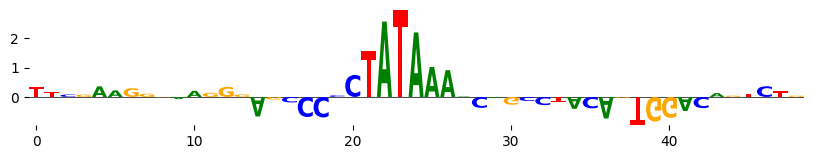

In [12]:
plot_attributions(attr_e[:, tss_pos-50:tss_pos], figsize=(10,1.5))

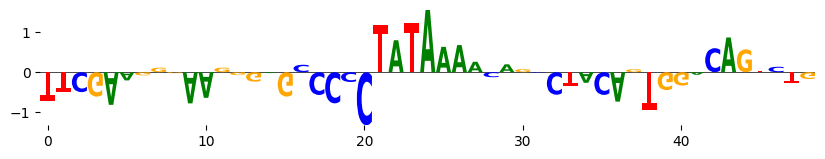

In [13]:
plot_attributions(attr_h[:, tss_pos-50:tss_pos], figsize=(10,1.5))

## View a distal enhancer

In [14]:
start_coord=88179510
end_coord=88179590

end_pos = ad.var.loc[gene, 'end']- start_coord
start_pos = ad.var.loc[gene, 'end'] - end_coord
start_pos, end_pos

(np.int64(112312), np.int64(112392))

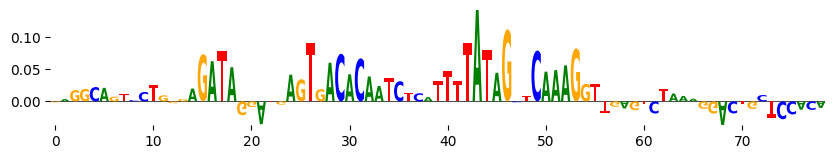

In [15]:
plot_attributions(attr_e[:, start_pos:end_pos], figsize=(10, 1.5))

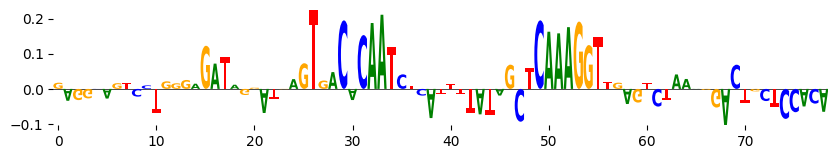

In [16]:
plot_attributions(attr_h[:, start_pos:end_pos], figsize=(10, 1.5))

In [17]:
off_tasks = ad.obs_names[(ad.obs.organ=='gut') & (ad.obs.cell_type!='enterocyte')].tolist()

## Scan enhancer peaks for motifs

In [18]:
s = scan_sequences('AGTGACACAATCA', motifs=motifs, pthresh=1e-3)
print(s)
for m in s.motif.tolist():
    m = m.split(".")[0]
    if m in ad.var_names:
        m_on=ad[e_tasks, m].X.mean() 
        m_off=ad[off_tasks, m].X.mean()
        if m_on-m_off >= 1:
            print(m, m_on-m_off)

                    motif sequence  seq_idx start end strand  fimo_score  \
0      ATF1.H12CORE.0.P.B        0        0     0  10      +    7.844383   
1      ATF2.H12CORE.1.P.B        0        0     1  12      -    3.415411   
2      ATF3.H12CORE.1.P.B        0        0     0  10      +    8.033084   
3      ATF3.H12CORE.2.P.B        0        0     0  12      +    4.899570   
4    ATF7.H12CORE.0.PSM.A        0        0     1  12      -    1.133153   
5      BATF.H12CORE.1.P.B        0        0     0  11      +    8.339195   
6     CEBPA.H12CORE.0.P.B        0        0     0  12      +    5.945682   
7     CEBPB.H12CORE.0.P.B        0        0     0  11      +    5.910642   
8     CEBPG.H12CORE.0.P.B        0        0     0  12      -    6.191722   
9     CEBPG.H12CORE.2.P.B        0        0     0  12      -    0.536704   
10    CREB5.H12CORE.0.P.B        0        0     1  12      -    7.020004   
11     ESR1.H12CORE.1.P.B        0        0     0   9      +    8.120621   
12     FOSB.

/opt/conda/lib/python3.11/site-packages/memelite/fimo.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [19]:
s = scan_sequences('ATTTTATAGCTC', motifs=motifs, pthresh=2.5e-3)
print(s)
for m in s.motif.tolist():
    m = m.split(".")[0]
    if m in ad.var_names:
        m_on=ad[e_tasks, m].X.mean() 
        m_off=ad[off_tasks, m].X.mean()
        if m_on-m_off >= 1:
            print(m, m_on-m_off)

                  motif sequence  seq_idx start end strand  fimo_score  \
0    CDX1.H12CORE.0.M.B        0        0     0  11      +    5.349007   
1   CPEB1.H12CORE.0.S.B        0        0     0   8      +   10.306152   
2   HXA13.H12CORE.0.P.B        0        0     0  10      +    7.773022   
3    HXA9.H12CORE.2.P.B        0        0     1  11      +   13.392345   
4  HXD13.H12CORE.0.PS.A        0        0     0  11      +   11.783088   

   fimo_p-value  matched_seq  
0      0.001595  ATTTTATAGCT  
1      0.000244     ATTTTATA  
2      0.000223   ATTTTATAGC  
3      0.000015   TTTTATAGCT  
4      0.000055  ATTTTATAGCT  
CDX1 3.370000307793956


/opt/conda/lib/python3.11/site-packages/memelite/fimo.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [20]:
s = scan_sequences('TAGCTCAAAGGTTGAG', motifs=motifs, pthresh=1e-3)
print(s)
for m in s.motif.tolist():
    m = m.split(".")[0]
    if m in ad.var_names:
        m_on=ad[e_tasks, m].X.mean() 
        m_off=ad[off_tasks, m].X.mean()
        if m_on-m_off >= 1:
            print(m, m_on-m_off)

                    motif sequence  seq_idx start end strand  fimo_score  \
0    ERR1.H12CORE.0.PSM.A        0        0     4  15      +    5.794093   
1   HNF4A.H12CORE.0.PSM.A        0        0     0  15      +    7.001691   
2    LEF1.H12CORE.0.PSM.A        0        0     0  12      -    7.827381   
3    NR2C2.H12CORE.1.PS.A        0        0     0  15      +   11.367464   
4     NR2F6.H12CORE.0.P.C        0        0     0  14      +    7.351575   
5    NR4A2.H12CORE.0.SM.B        0        0     5  15      +    8.666263   
6     PPARA.H12CORE.1.P.B        0        0     5  14      +    7.226722   
7     RXRA.H12CORE.2.SM.B        0        0     0  15      +   11.393844   
8     SOX15.H12CORE.0.P.B        0        0     3  11      -    7.663924   
9    TF7L1.H12CORE.0.PM.A        0        0     0  12      -    7.582001   
10    TF7L2.H12CORE.0.P.B        0        0     0  12      -    8.417397   
11     THB.H12CORE.2.SM.B        0        0     1  15      +   13.076248   

    fimo_p-

/opt/conda/lib/python3.11/site-packages/memelite/fimo.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


## View logos

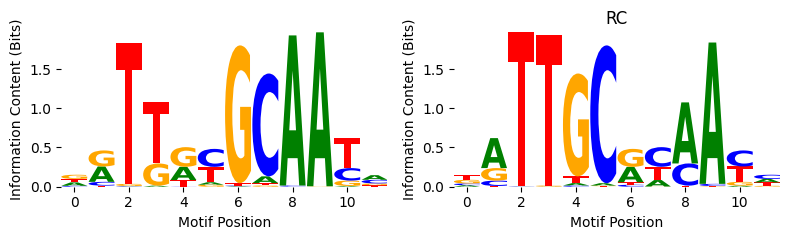

In [21]:
for n, m in motifs.items():
    if 'CEBPA' in n:
        break

plot_motif(m.T)

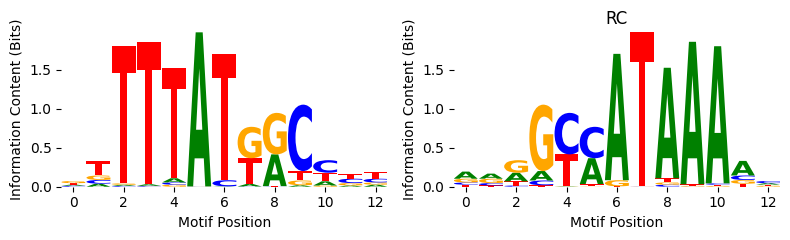

In [22]:
for n, m in motifs.items():
    if 'CDX2' in n:
        break

plot_motif(m.T)

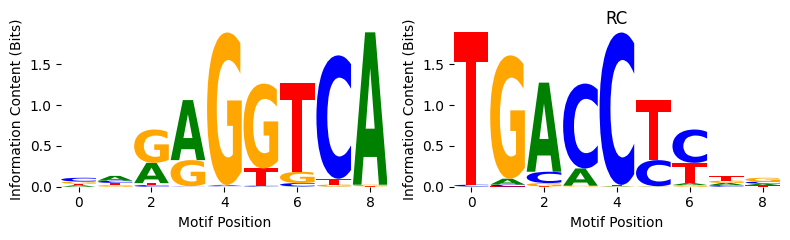

None

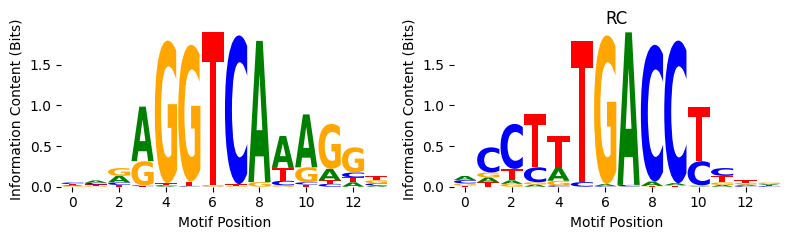

None

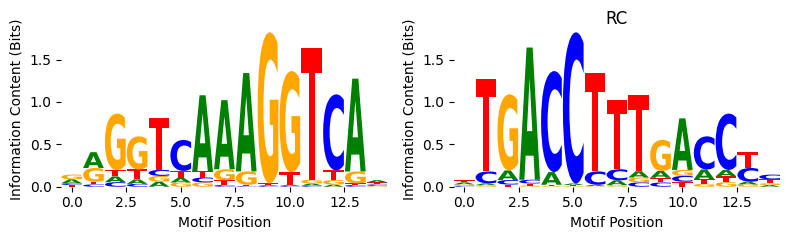

None

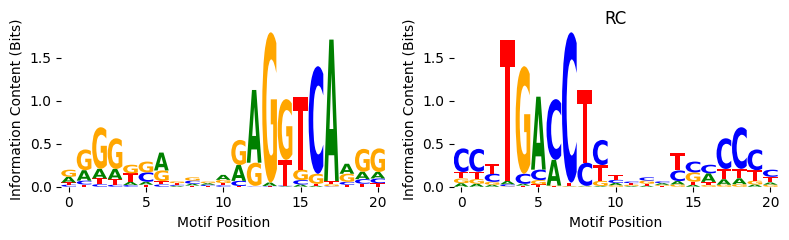

None

In [23]:
for n, m in motifs.items():
    if 'RXRA' in n:
        display(plot_motif(m.T))

## View TF abundance

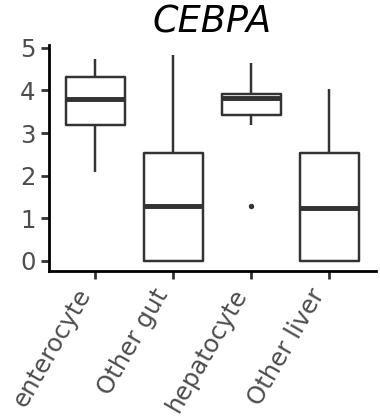

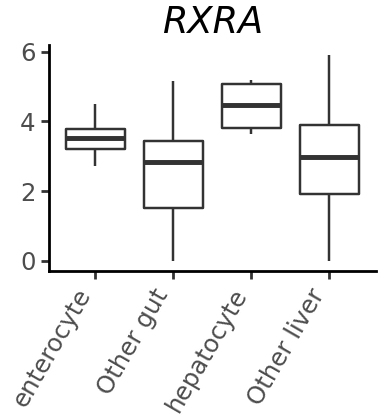

In [24]:
for gene in ['CEBPA', 'RXRA']:
    p=plot_marker_box(
        gene=gene, ad=ad[ad.obs.organ.isin(['liver', 'gut'])], 
        marker_features={'cell_type':['hepatocyte', 'enterocyte']},
        split_col='organ', split_values=['gut', 'liver'], label_name='Cell type',
        order=['enterocyte', 'Other gut', 'hepatocyte', 'Other liver'],
        include_preds=False, fill=False) + theme(figure_size=(1.9,2.1))  +\
    theme(axis_title_y=element_blank())
    display(p)

# See the next notebook to generate the same plot for CDX2